<a href="https://colab.research.google.com/github/WillieHabim/COMP551-A2/blob/main/COMP551_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1.1

##Task 1.1

Get Data

In [20]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 

--2022-11-02 11:28:25--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  49.7MB/s    in 1.6s    

2022-11-02 11:28:27 (49.7 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [21]:
!tar --gunzip --extract --file=aclImdb_v1.tar.gz 

In [22]:
import pandas as pd

words_table = pd.read_csv('aclImdb/imdb.vocab', header=None)
words_table.head()

,0
0,the
1,and
2,a
3,of
4,to


In [23]:
!pip install -U libsvm-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import numpy as np
np.random.seed(3)
words = words_table.to_numpy()
words.shape

(89527, 1)

In [25]:
valid_indices = [1 for i in range(words.shape[0])]
len(valid_indices)

89527

Remove rare and stopwords

In [26]:
import scipy
from libsvm.svmutil import *
y, x = svm_read_problem('aclImdb/train/labeledBow.feat', return_scipy = True) # y: ndarray, x: csr_matrix
appearances = (x != 0).sum(0)
ratios = appearances/y.shape[0]
valid_imdb_indices = np.where((ratios < .01) | (ratios > 0.5), False, True).flatten()
invalid_indices = np.logical_not(valid_indices)

In [150]:
valid_imdb_indices = np.array(valid_imdb_indices, dtype=bool)
valid_words = words[valid_imdb_indices, :]
X_imdb = x[:, valid_imdb_indices]
y_imdb = y
y_imdb = (y_imdb >= 5).astype(int)

Find 100 top features/words by absolute z-score 

In [151]:
from sklearn.preprocessing import StandardScaler
import math

scaler = StandardScaler()
x_standard = scaler.fit_transform(X_imdb.toarray())
y_standard = scaler.fit_transform(y_imdb.reshape(-1,1)).flatten()

z = (np.dot(x_standard.T, y_standard))/math.sqrt(y.shape[0])
best_features_imdb = np.argsort(abs(z))[::-1][:100]

##Task 1.2

Getting best features from news dataset

In [29]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mutual_info_score
from heapq import heappush, heappushpop

bunch = fetch_20newsgroups(subset="train", categories=['rec.motorcycles', 'soc.religion.christian', 'sci.med', 'comp.windows.x'], remove=(['headers', 'footers', 'quotes']))
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(bunch.data)

# 4 categories:
# -------
# 1) rec.motorcycles 8
# 2) soc.religion.christian 15
# 3) sci.med 13
# 4) comp.windows.x 5

# category_indices = np.where((bunch.target == 8) | (bunch.target == 5) |(bunch.target == 15) |(bunch.target == 13), True, False).tolist()
# X_train_counts = X_train_total_counts[category_indices, :]

# One-hot Encoding
# -----------------
y_news_train = np.zeros((bunch.target.size, 4))
y_news_train[np.arange(bunch.target.size), bunch.target] = 1

ratios = ((X_train_counts != 0).sum(0))/y_news_train.shape[0]
valid_news_indices = np.where((ratios < .01) | (ratios > 0.5), False, True).flatten()
valid_news_indices = np.array(valid_news_indices, dtype=bool)

X_news = X_train_counts[:, valid_news_indices]
best_features_news = set()

for i in range(4):
  minheap = []
  for j in range(X_news.shape[1]):
    mis = mutual_info_score(y_news_train[:,i], X_news[:,j].toarray().flatten())
    if len(minheap) < 100:
      heappush(minheap, (mis,j))
    elif minheap[0][0] < mis:
      heappushpop(minheap, (mis,j))
  
  new_words = set([i for (_,i) in minheap])
  best_features_news.update(new_words)

X_news_train = X_news[:, list(best_features_news)]

#Task 2

Logistic Regression

In [162]:
logistic = lambda a: 1.0 / (1 + np.exp(-a))

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.05, epsilon=1e-4, max_iters=1000):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        
        self.max_iters = max_iters                  

    def gradient(self, x, y):
        yh = logistic(np.dot(x, self.w))    
        grad = np.dot(x.T, yh - y)/x.shape[0]
        return grad

    def ce(self, X, y):
      a = np.dot(X, self.w)
      return np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a)))
         
    def fit(self, x, y, x_valid=None, y_valid=None):
        if x.ndim == 1:
            x = x[:, None]
            if x_valid is not None:
              x_valid = x_valid[:, None]
        if self.add_bias:
            x = np.column_stack([x,np.ones(x.shape[0])])
            if x_valid is not None:
              x_valid = np.column_stack([x_valid,np.ones(x_valid.shape[0])])
        self.w = np.array(np.zeros(x.shape[1]), dtype=np.float128)
        
        g = np.inf 
        t = 0
        self.losses = np.array([])
        if x_valid is not None and y_valid is not None:
          self.losses_valid = np.array([])
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            self.losses = np.append(self.losses, self.ce(x,y))
            if x_valid is not None and y_valid is not None:
              cost = self.ce(x_valid,y_valid)
              #print(f"iter {t}: {cost}")
              self.losses_valid = np.append(self.losses_valid, cost)
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            x = np.column_stack([x,np.ones(x.shape[0])])
        y_hat = logistic(np.dot(x,self.w))            
        return y_hat

    def check_g(self, x, y):
      N,D = x.shape
      diff = np.zeros(D+1)
      w = np.array(self.w.copy(), dtype=np.float128)

      if self.add_bias:
        x = np.column_stack([x,np.ones(x.shape[0])])

      for i in range(D+1):
        epsilon = np.zeros(D+1)
        epsilon[i] = np.random.randn(1)[0] * 1e-5
        self.w = self.w + epsilon
        ce1 = self.ce(x, y)
        self.w = w

        self.w = self.w - epsilon
        ce2 = self.ce(x, y)
        self.w = w
        
        numeric_g = (ce1 - ce2) / (2*epsilon[i])
        derived_g = self.gradient(x,y)[i]*N
        
        diff[i] = np.square(derived_g - numeric_g) / np.square(derived_g + numeric_g)
      
      return np.nansum(diff)




Training on IMDB Data

In [163]:
from sklearn import model_selection
model = LogisticRegression()
X_imdb_train, X_imdb_valid, y_imdb_train, y_imdb_valid = model_selection.train_test_split(
    X_imdb, y_imdb, test_size = 0.5, random_state=1, shuffle=True)

X_imdb_train_scaled = np.array(scaler.fit_transform(X_imdb_train[:,best_features_imdb].toarray()), dtype=np.float128)
X_imdb_valid_scaled = scaler.fit_transform(X_imdb_valid[:,best_features_imdb].toarray())
fit = model.fit(X_imdb_train_scaled, y_imdb_train, X_imdb_valid_scaled, y_imdb_valid)
optimal_iter = fit.losses_valid.argmin()
print(optimal_iter)
#Retrain model with opitmal iter
model = LogisticRegression(max_iters=optimal_iter)
X_imdb_scaled = np.array(scaler.fit_transform(X_imdb[:,best_features_imdb].toarray()), dtype=np.float128)
fit = model.fit(X_imdb_scaled, y_imdb)

602


Testing on IMDB Data

In [164]:
from sklearn.metrics import roc_curve, roc_auc_score
y_imdb_test, X_imdb_test = svm_read_problem('aclImdb/test/labeledBow.feat', return_scipy = True) # y: ndarray, x: csr_matrix
X_imdb_test = X_imdb_test[:,valid_imdb_indices]
y_imdb_pred = fit.predict(X_imdb_test[:,best_features_imdb].toarray())
y_imdb_test = (y_imdb_test >= 5).astype(int)
auroc = roc_auc_score(y_imdb_test, y_imdb_pred)
auroc

0.8778829824000001

Multiclass Regression

In [33]:
class MulticlassRegression:

  def __init__(self, num_features, num_classes, learning_rate=.0005, epsilon=1e-4, max_iters=1e3):
      #populate W with values from a random sample from a uniform distribution
      self.lr = learning_rate
      self.epsilon = epsilon
      self.max_iters = math.floor(max_iters)
      self.num_features = num_features
      self.num_classes = num_classes
      self.W = np.random.rand(num_features, num_classes)
      

  def predict(self, x):
    #compute product XW
    z = x @ self.W
    #compute soft max
    #adjust terms 
    z_max = z.max(axis=1)
    z = z - np.tile(z_max, (4, 1)).transpose()
    y_pred = np.exp(z)
    return y_pred / y_pred.sum(axis=1).reshape(x.shape[0], 1)

  def gradient(self, x, y):
    x_t = np.transpose(x)
    return x_t @ (self.predict(x) - y) 

  def cost(self, x, y):
    return -np.nansum(y * np.log(self.predict(x)))

  def fit(self, x, y, x_valid=None, y_valid=None):
    loss_train = np.array([])
    loss_valid = np.array([])
    for n in range(self.max_iters):
      g = self.gradient(x, y)
      self.W = self.W - self.lr * g
      cost = self.cost(x,y)
      loss_train = np.append(loss_train, cost)
      if x_valid is not None and y_valid is not None:
        loss_valid = np.append(loss_valid, self.cost(x_valid, y_valid))
      if np.linalg.norm(g) < self.epsilon:
        break
    
    return loss_train, loss_valid
  
  def check_grad(self, x, y):
    N, C = y.shape
    D = x.shape[1]

    diff = np.zeros((D, C))

    W = self.W.copy()

    for i in range(D):
      for j in range(C):
        epsilon = np.zeros((D, C))
        epsilon[i, j] = np.random.rand() * 1e-4

        self.W = self.W + epsilon
        J1 = self.cost(x, y)
        self.W = W

        self.W = self.W - epsilon
        J2 = self.cost(x, y)
        self.W = W

        numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
        derived_grad = self.gradient(x, y)[i, j]

        diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                      np.square(derived_grad + numeric_grad).sum()


    return diff.sum()


Training on News Dataset

In [34]:
model = MulticlassRegression(X_news_train.shape[1], y_news_train.shape[1])
# X_news_train_scaled = scaler.fit_transform(X_news_train.toarray())
X_news_train_, X_news_valid, y_news_train_, y_news_valid = model_selection.train_test_split(
    X_news_train, y_news_train, test_size = 0.5, random_state=1, shuffle=True)
X_news_train_scaled = scaler.fit_transform(X_news_train_.toarray())
X_news_valid_scaled = scaler.fit_transform(X_news_valid.toarray())
ce_train, ce_valid = model.fit(X_news_train_scaled, y_news_train_, X_news_valid_scaled, y_news_valid)
optimal_iter = ce_valid.argmin()
print(optimal_iter)
#Retrain model using optimal iter
model = MulticlassRegression(X_news_train.shape[1], y_news_train.shape[1], max_iters=optimal_iter)
X_news_train_scaled = scaler.fit_transform(X_news_train.toarray())
ce_train, ce_valid = model.fit(X_news_train_scaled, y_news_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


250


Testing on News Dataset

In [35]:
bunch_test = fetch_20newsgroups(subset="test", categories=['rec.motorcycles', 'soc.religion.christian', 'sci.med', 'comp.windows.x'], remove=(['headers', 'footers', 'quotes']))
count_vect_test = CountVectorizer()
X_test_counts = count_vect_test.fit_transform(bunch_test.data)
test_words = count_vect_test.vocabulary_
valid_words = count_vect.get_feature_names_out()[valid_news_indices]
feature_names = valid_words[list(best_features_news)]
X_news_test = np.zeros((X_test_counts.shape[0], X_news_train.shape[1]))
for i in range(feature_names.shape[0]):
  if feature_names[i] in test_words:
    X_news_test[:,i] = X_test_counts[:,test_words[feature_names[i]]].toarray().flatten()

y_test_news = np.zeros((bunch_test.target.size, 4))
y_test_news[np.arange(bunch_test.target.size), bunch_test.target] = 1
y_news_pred = model.predict(X_news_test)

accuracy = sum(y_news_pred.argmax(axis=1) == y_test_news.argmax(axis=1))
accuracy = accuracy / y_test_news.shape[0]
accuracy

0.7561436672967864

KNN Comparison

In [170]:
from sklearn.neighbors import KNeighborsClassifier
max_imdb_score = 0
max_news_score = 0
x_imdb_test = X_imdb_test[:,best_features_imdb].toarray()

for k in [1,5,10]:
  knn_imdb = KNeighborsClassifier(k)
  knn_imdb.fit(X_imdb_scaled, y_imdb)
  pred = knn_imdb.predict(x_imdb_test)
  score = roc_auc_score(y_imdb_test, pred)
  max_imdb_score = max(max_imdb_score, score)

  knn_news = KNeighborsClassifier(k)
  knn_news.fit(X_news_train, y_news_train)
  score = knn_news.score(X_news_test, y_test_news)
  max_news_score = max(max_news_score, score)

print(f"IMDB auroc: {max_imdb_score}")
print(f"News accuracy: {max_news_score}")




IMDB auroc: 0.6594
News accuracy: 0.4612476370510397


##Task 2.1

Gradient of Logisitic Regression Model

In [165]:
fit.check_g(X_imdb_scaled, y_imdb)

100.98384129101971

Gradient of Multiclass Regression Model

In [38]:
model.check_grad(X_news_train_scaled, y_news_train)

1.678450100353709e-10

CE vs Iteration of Logistic Regression

Text(0.5, 1.0, 'Cross entropy vs Iteration: Logisitic Regression model on IMDB dataset ')

<Figure size 432x288 with 0 Axes>

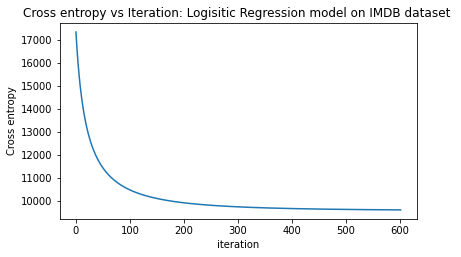

In [168]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.plot(fit.losses)
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
plt.title("Cross entropy vs Iteration: Logisitic Regression model on IMDB dataset ")

CE vs Iteration of Multiclass Regression Model

Text(0.5, 1.0, 'Cross entropy vs Iteration: Multiclass Regression model on 20-news-group dataset ')

<Figure size 432x288 with 0 Axes>

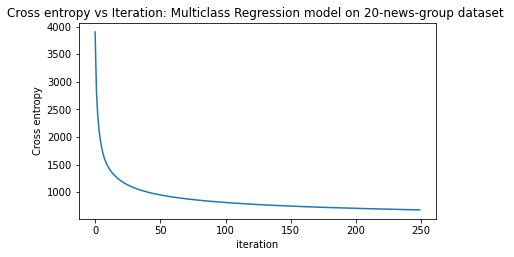

In [169]:
plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.plot(ce_train)
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
plt.title("Cross entropy vs Iteration: Multiclass Regression model on 20-news-group dataset ")